# Gradient wind balance in mesoscale Eddy

In [1]:
import numpy as np
import xarray as xr

from stsci.convolve import boxcar
from scipy.ndimage import uniform_filter, gaussian_filter

from oceanpy import gradient_wind_from_ssh

import matplotlib.pyplot as plt
import cmocean as cmo

## Make a Sea Surface Height (SSH) field with the use of the Rossby radius of deformation

$$ L_R = \frac{\left(gD\right)^{1/2}}{f} $$

In [2]:
# Characteristic length and height scale Mesoscale eddies
L = 100e3
H = 0.1

# Calculate Rossby radius of deformation
f = 1e-4 # Coriolis parameter
D = 4000 # water depth
g = 9.81 # gravitational acceleration
L_Ro = (g * D)**(1/2) / f

# Make grid
xi = np.linspace(-1.5*L/2, 1.5*L/2, 101)
xx, yy = np.meshgrid(xi, xi)
R = np.sqrt((xx / L_Ro)**2 + (yy / L_Ro)**2)

# Create cyclonic and anticyclonic SSH field
ssh = H * np.exp(-D * R**2)

## Store the SSH field for a cyclone and a anticyclone in a Xarray Dataset

In [3]:
# ssh = xr.DataArray(
#     data=ssh[np.newaxis],
#     dims=['time', 'y', 'x'],
#     coords=dict(
#         x=(['x'], xi),
#         y=(['y'], xi),
#         time=[0])
# )

ssh_ds = xr.Dataset(
    data_vars=dict(
        cyclone=(['time', 'y', 'x'], -ssh[np.newaxis]),
        anticyclone=(['time', 'y', 'x'], ssh[np.newaxis])),
    coords=dict(
        x=(['x'], xi),
        y=(['y'], xi),
        time=[0])
)

In [4]:
ssh_ds

<xarray.Dataset>
Dimensions:      (time: 1, x: 101, y: 101)
Coordinates:
  * x            (x) float64 -7.5e+04 -7.35e+04 -7.2e+04 ... 7.35e+04 7.5e+04
  * y            (y) float64 -7.5e+04 -7.35e+04 -7.2e+04 ... 7.35e+04 7.5e+04
  * time         (time) int64 0
Data variables:
    cyclone      (time, y, x) float64 -1.046e-06 -1.313e-06 ... -1.046e-06
    anticyclone  (time, y, x) float64 1.046e-06 1.313e-06 ... 1.046e-06

## Calculate the geostrophic, gradient wind and ageostrophic velocities for the SSH fields

$$ u_a = u - u_g $$

In [5]:
gw_cyclone = gradient_wind_from_ssh(ssh_ds.cyclone, dimensions=('time', 'y', 'x'), transform='xy')
gw_anticyclone = gradient_wind_from_ssh(ssh_ds.anticyclone, dimensions=('time', 'y', 'x'), transform='xy')

/home/janjaapmeijer/checkouts/oceanpy/obs/satellite.py:346: RuntimeWarning: invalid value encountered in true_divide
  / (detadx**2 + detady**2)**(3/2)


In [6]:
uag_cyclone = gw_cyclone.ugrad - gw_cyclone.ugeos
vag_cyclone = gw_cyclone.vgrad - gw_cyclone.vgeos
uag_cyclone.name, vag_cyclone.name = 'uag', 'vag'
ag_cyclone = xr.merge([uag_cyclone, vag_cyclone])

In [7]:
uag_anticyclone = gw_anticyclone.ugrad - gw_anticyclone.ugeos
vag_anticyclone = gw_anticyclone.vgrad - gw_anticyclone.vgeos
uag_anticyclone.name, vag_anticyclone.name = 'uag', 'vag'
ag_anticyclone = xr.merge([uag_anticyclone, vag_anticyclone])

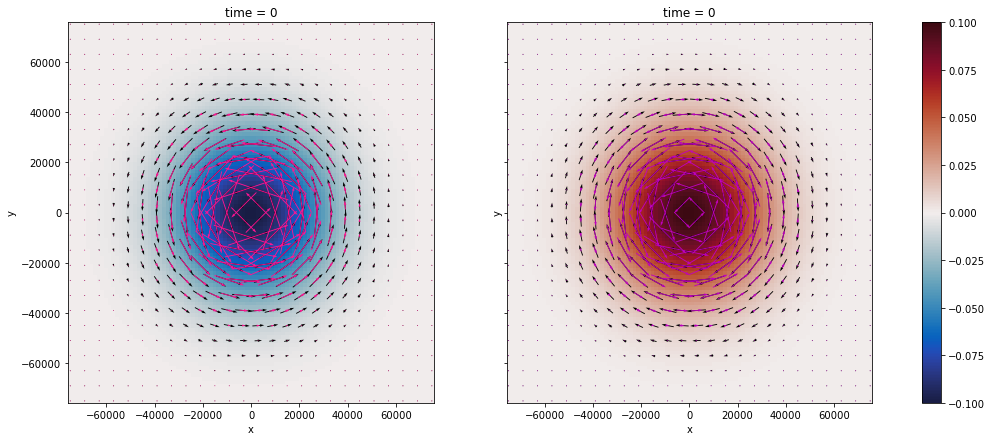

In [8]:
vmin, vmax = -0.1, 0.1

fig, ax = plt.subplots(figsize=(18,7), ncols=2, sharey=True)

# plot SSH fields
pcol = ssh_ds.cyclone.plot(ax=ax[0],
    cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, add_colorbar=False)
pcol = ssh_ds.anticyclone.plot(ax=ax[1],
    cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, add_colorbar=False)
fig.colorbar(pcol, ax=ax)

# plot gradient wind vectors
gw_cyclone.isel(time=0).sel(x=slice(None, None, 4), y=slice(None, None, 4)).plot.quiver(
    ax=ax[0], x='x', y='y', u='ugrad', v='vgrad')
gw_anticyclone.isel(time=0).sel(x=slice(None, None, 4), y=slice(None, None, 4)).plot.quiver(
    ax=ax[1], x='x', y='y', u='ugrad', v='vgrad')

# plot ageostrophic vectors
ag_cyclone.isel(time=0).sel(x=slice(None, None, 4), y=slice(None, None, 4)).plot.quiver(
    ax=ax[0], x='x', y='y', u='uag', v='vag', facecolors='deeppink')
ag_anticyclone.isel(time=0).sel(x=slice(None, None, 4), y=slice(None, None, 4)).plot.quiver(
    ax=ax[1], x='x', y='y', u='uag', v='vag', facecolors='m')

## Smoothing filter

In [9]:
# Adding some random noise to the field
ssh_noise = ssh + np.random.normal(loc=0, scale=0.01, size=xx.shape)

# Apply the filter to a 3x3 window
window = 3
ssh_boxcar = uniform_filter(ssh_noise, window)
ssh_gauss = gaussian_filter(ssh_noise, window)

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:4: M

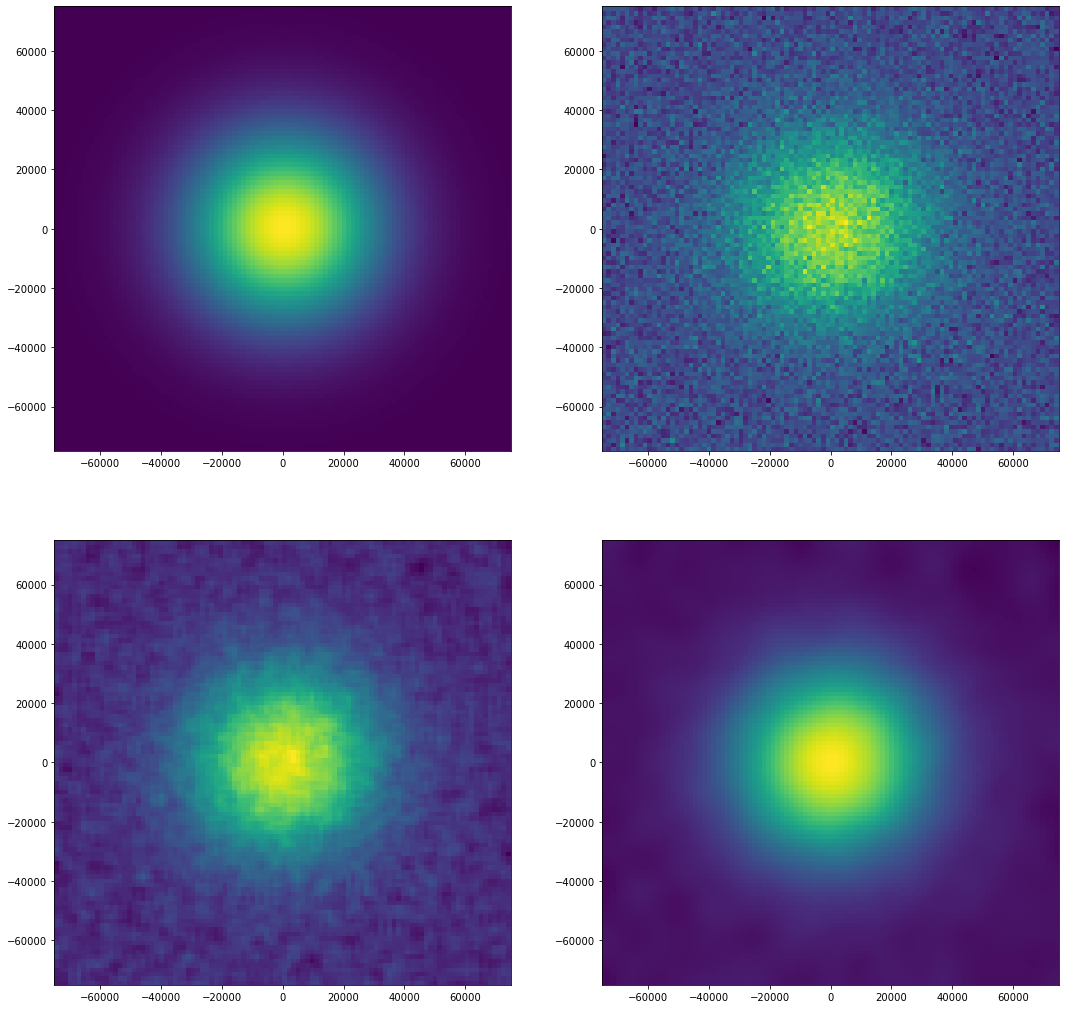

In [10]:
fig, ax = plt.subplots(ncols = 2, nrows=2, figsize=(18,18))
ax[0, 0].pcolormesh(xx, yy, ssh)
ax[0, 1].pcolormesh(xx, yy, ssh_noise)
ax[1, 0].pcolormesh(xx, yy, ssh_boxcar)
ax[1, 1].pcolormesh(xx, yy, ssh_gauss)